# Exploration Summary
## Yihnew Eshetu (yte9pc), Nathan England (nle4bz), and Karyne Williams (kw7me)

In [11]:
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import DenseVector, Vectors
from pyspark.ml.feature import StandardScaler, VectorAssembler, ChiSqSelector, VectorIndexer, StringIndexer, OneHotEncoder
from pyspark.ml.regression import *
from pyspark.ml import Pipeline 
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

## Yellow Cab

In [2]:
def yellowCSVToDF():
    location = "/sfs/qumulo/qhome/yte9pc/Project/Yellow_Cab_Data/Data/Raw_Data/"

    files = sorted(glob.glob(location + '*.csv'))

    for idx,f in enumerate(files):
        df = spark.read.csv(f, header = True)
        print(f)

        if idx == 0:
            data = df
        else:
            data = data.union(df)
    return data

In [3]:
data = yellowCSVToDF()

/sfs/qumulo/qhome/yte9pc/Project/Yellow_Cab_Data/Data/Raw_Data/yellow_tripdata_2019-05.csv
/sfs/qumulo/qhome/yte9pc/Project/Yellow_Cab_Data/Data/Raw_Data/yellow_tripdata_2019-06.csv
/sfs/qumulo/qhome/yte9pc/Project/Yellow_Cab_Data/Data/Raw_Data/yellow_tripdata_2019-07.csv
/sfs/qumulo/qhome/yte9pc/Project/Yellow_Cab_Data/Data/Raw_Data/yellow_tripdata_2019-08.csv


In [4]:
data.printSchema()

root
 |-- VendorID: string (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_distance: string (nullable = true)
 |-- RatecodeID: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: string (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: string (nullable = true)
 |-- extra: string (nullable = true)
 |-- mta_tax: string (nullable = true)
 |-- tip_amount: string (nullable = true)
 |-- tolls_amount: string (nullable = true)
 |-- improvement_surcharge: string (nullable = true)
 |-- total_amount: string (nullable = true)
 |-- congestion_surcharge: string (nullable = true)



In [5]:
data = data.withColumn("tpep_pickup_datetime", data["tpep_pickup_datetime"].cast(TimestampType()))\
    .withColumn("tpep_dropoff_datetime", data["tpep_dropoff_datetime"].cast(TimestampType()))\
    .withColumn("passenger_count", data["passenger_count"].cast(IntegerType()))\
    .withColumn("trip_distance", data["trip_distance"].cast(FloatType()))\
    .withColumn("fare_amount", data["fare_amount"].cast(FloatType()))\
    .withColumn("extra", data["extra"].cast(FloatType()))\
    .withColumn("mta_tax", data["mta_tax"].cast(FloatType()))\
    .withColumn("tip_amount", data["tip_amount"].cast(FloatType()))\
    .withColumn("tolls_amount", data["tolls_amount"].cast(FloatType()))\
    .withColumn("improvement_surcharge", data["improvement_surcharge"].cast(FloatType()))\
    .withColumn("total_amount", data["total_amount"].cast(FloatType()))\
    .withColumn("congestion_surcharge", data["congestion_surcharge"].cast(FloatType()))

data.printSchema()

root
 |-- VendorID: string (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: float (nullable = true)
 |-- RatecodeID: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: string (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: float (nullable = true)
 |-- extra: float (nullable = true)
 |-- mta_tax: float (nullable = true)
 |-- tip_amount: float (nullable = true)
 |-- tolls_amount: float (nullable = true)
 |-- improvement_surcharge: float (nullable = true)
 |-- total_amount: float (nullable = true)
 |-- congestion_surcharge: float (nullable = true)



## Count of rows and columns

In [6]:
print('Count of rows: {0}'.format(data.count()))
print('Count of columns: {0}'.format(len(data.columns)))

Count of rows: 17940833
Count of columns: 18


In [12]:
data = data.dropna()
data = data.filter(((data.total_amount >= 0) & (data.payment_type <= 2)) | (data.payment_type > 2))
data = data.filter((col('trip_distance') >= 0))

## Statistical summary of response variables
- Possible response variable
    - Payment Type
    - Tip Amount

In [13]:
def percentage(column):
    count_level = data.groupby(column).count()
    count_level_per = count_level.withColumn('percentage', count_level['count']/ float(data.count())).orderBy(F.col(column))
    
    return count_level_per

In [39]:
def bar(df, x, y):
    labels = ['Credit Card', 'Cash', 'No charge', 'Dispute', 'Unknown']
    count = df.toPandas()[y]
    ind = [x for x, _ in enumerate(labels)]
    colors = ['gold', 'yellowgreen', 'lightcoral', 'blue', 'lightskyblue', 'green']

    plt.figure(figsize=(10,8))
    plt.bar(ind, count, width=0.8, label='count', color=colors)

    plt.xticks(ind, labels)
    plt.ylabel(y)
    plt.xlabel('Payment Types')
    plt.title('Count of Payment Types')
    plt.savefig('bar.png')
    plt.show()
   
    

def hist(df, x):
    values = df.toPandas()[x]
    bins = np.arange(0, 100, 5.0)

    plt.figure(figsize=(10,8))
    # the histogram of the data
    plt.hist(values, bins, alpha=0.8, histtype='bar', color='gold',
         ec='black',weights=np.zeros_like(values) + 100. / values.size)

    plt.xlabel(x)
    plt.ylabel('count')
    plt.xticks(bins)
    plt.show()

In [35]:
paymentType = percentage('payment_type')
paymentType.show()

+------------+--------+--------------------+
|payment_type|   count|          percentage|
+------------+--------+--------------------+
|           1|12698184|  0.7092632923359621|
|           2| 5063177|  0.2828062334503673|
|           3|  100892|0.005635372120167725|
|           4|   41089|0.002295046238012...|
|           5|       1|5.585549022883603E-8|
+------------+--------+--------------------+



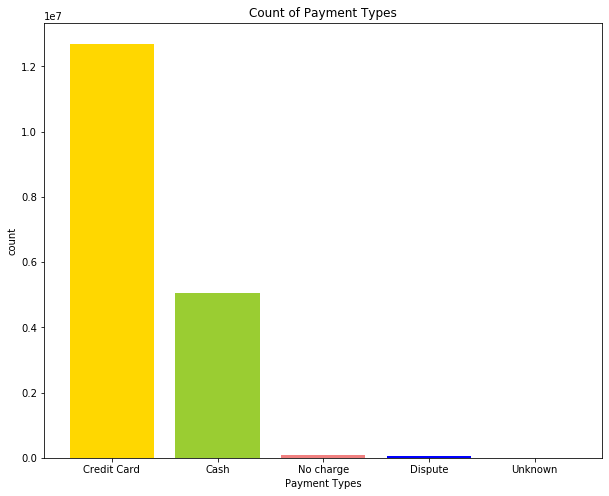

In [40]:
bar(paymentType, 'payment_type', 'count')

In [43]:
data = data.withColumn("pickup_week_day", date_format("tpep_pickup_datetime", "u").cast(IntegerType()))\
    .withColumn("pickup_hour", hour("tpep_pickup_datetime"))\
    .withColumn("dropoff_week_day", date_format("tpep_dropoff_datetime", "u").cast(IntegerType()))\
    .withColumn("dropoff_hour", hour("tpep_dropoff_datetime"))\
    .withColumn("trip_time(mins)", (col("tpep_dropoff_datetime").cast(LongType()) - col("tpep_pickup_datetime").cast(LongType()))/60)\
    .withColumn("distance/time", (col("trip_distance")/col("trip_time(mins)")))
tip_amount = data.filter(data.payment_type == 1)

In [49]:
tip_amount.select(['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
             'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'trip_time(mins)', 'distance/time']).printSchema()

root
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: float (nullable = true)
 |-- fare_amount: float (nullable = true)
 |-- extra: float (nullable = true)
 |-- mta_tax: float (nullable = true)
 |-- tip_amount: float (nullable = true)
 |-- tolls_amount: float (nullable = true)
 |-- improvement_surcharge: float (nullable = true)
 |-- total_amount: float (nullable = true)
 |-- congestion_surcharge: float (nullable = true)
 |-- trip_time(mins): double (nullable = true)
 |-- distance/time: double (nullable = true)



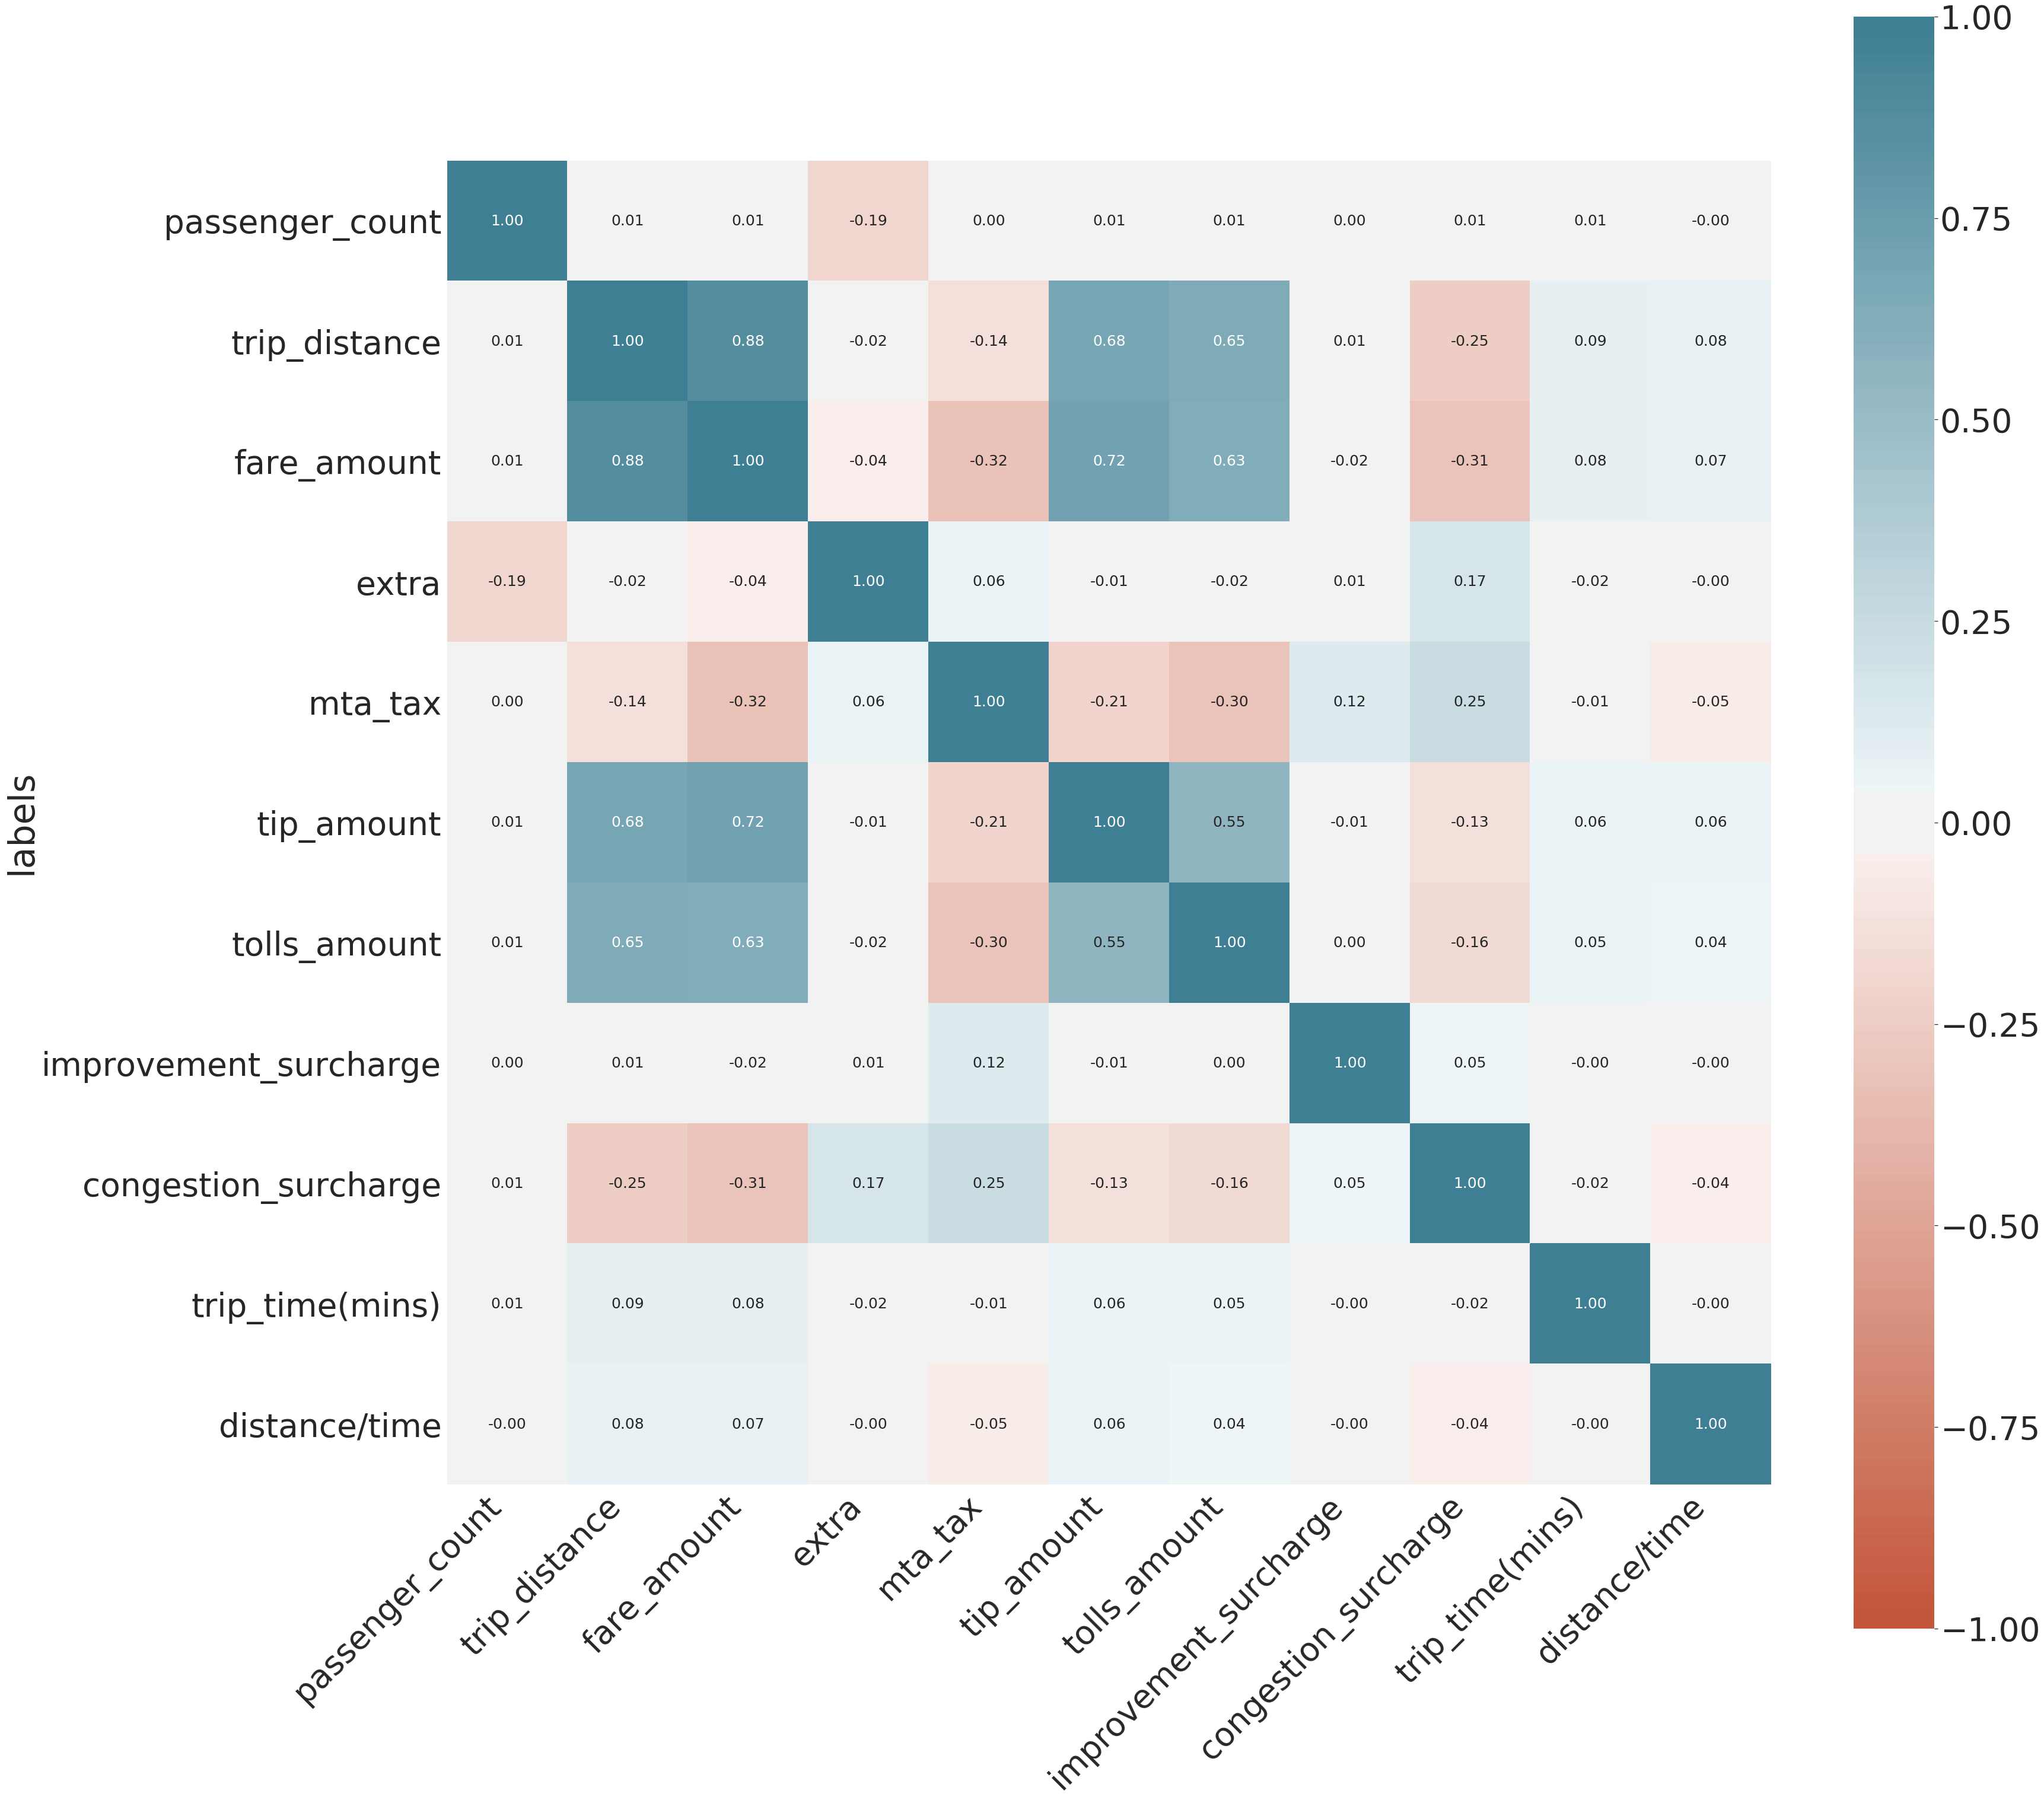

In [54]:
df_corr = tip_amount.select(['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
             'improvement_surcharge', 'congestion_surcharge', 'trip_time(mins)', 'distance/time'])
df_corr = df_corr.dropna()
df_corr = df_corr.select([col(c).cast("double").alias(c) for c in df_corr.columns])
assembler = VectorAssembler(inputCols=[col for col in df_corr.columns], outputCol="features")
dt = assembler.transform(df_corr)
tip_amount_corr = Correlation.corr(dt, "features").head()
corr = spark.createDataFrame(tip_amount_corr[0].toArray().tolist(), dt.columns[:-1])
corr = corr.toPandas()
corr['labels'] = dt.columns[:-1]
corr.set_index('labels', inplace = True)

fig, ax = plt.subplots(figsize=(50,50)) 
sns.set(font_scale=5)
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
    fmt=".2f",
    annot_kws={'size':25}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
sns.set(font_scale=5)
plt.savefig('corr.png')

In [25]:
filtertip = tip_amount.filter((tip_amount.tip_amount >= 0) & (tip_amount.tip_amount < 150))

In [26]:
hists = filtertip.select('tip_amount').rdd.flatMap(lambda row: row).histogram(20)

Text(0.5, 0, 'Tip Amount')

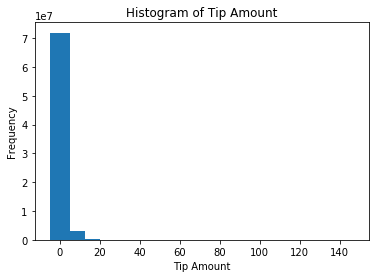

In [30]:
data_hist = {
    'bins': hists[0][:-1],
    'freq': hists[1]
    }
plt.bar(data_hist['bins'], data_hist['freq'], width=10)
plt.title('Histogram of ' + 'Tip Amount')
plt.ylabel('Frequency')
plt.xlabel('Tip Amount')

## Statistical summary of predictor variables

In [176]:
categorical = [c for c in data.columns if dict(data.select(c).dtypes)[c] == 'string']
for c in data.select(categorical).columns:
    percentage(c)

+--------+--------+--------------------+
|VendorID|   count|          percentage|
+--------+--------+--------------------+
|    null|  212642|0.002824502145002179|
|       1|27100009|  0.3599666742697979|
|       2|47727077|  0.6339539289565757|
|       4|  245044|0.003254894628624...|
+--------+--------+--------------------+

+----------+--------+--------------------+
|RatecodeID|   count|          percentage|
+----------+--------+--------------------+
|      null|  212642|0.002824502145002179|
|         1|72419257|  0.9619376545365642|
|         2| 1977218|0.026263186398439248|
|         3|  169433|0.002250561375147686|
|         4|   58673|7.793475153248787E-4|
|         5|  443577|0.005891988355892...|
|         6|     489|6.495337463464723E-6|
|        99|    3483|4.626433616615057E-5|
+----------+--------+--------------------+

+------------------+--------+--------------------+
|store_and_fwd_flag|   count|          percentage|
+------------------+--------+--------------------+
|

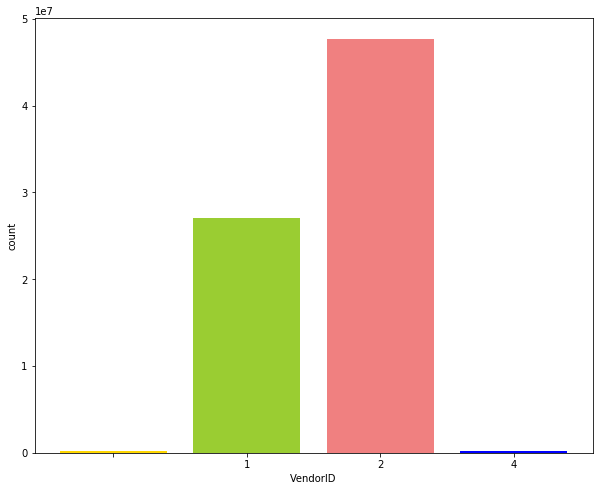

In [45]:
vendor = percentage('VendorID')
bar(vendor, 'VendorID', 'count')

In [179]:
numeric = list(set(df.columns) - set(categorical))
data.select(numeric).summary().show()

+-------+------------------+-------------------+------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+
|summary|             extra|            mta_tax|   passenger_count|improvement_surcharge|congestion_surcharge|      tolls_amount|     trip_distance|        tip_amount|       fare_amount|      total_amount|
+-------+------------------+-------------------+------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+
|  count|          75284769|           75284769|          75072130|             75284769|            70428788|          75284769|          75284772|          75284769|          75284769|          75284769|
|   mean|   1.0764021256393|0.49467046422089744|1.5619848537666374|   0.2986233801600075|  2.1778940963743407|0.3799363483043255|2.9900554357980926|2.1890400254703297| 13.29965

In [22]:
passenger = percentage('passenger_count')

labels = passenger.select('passenger_count').toPandas()
labels = labels['passenger_count']
sizes = passenger.select('count').toPandas()
sizes = sizes['count']

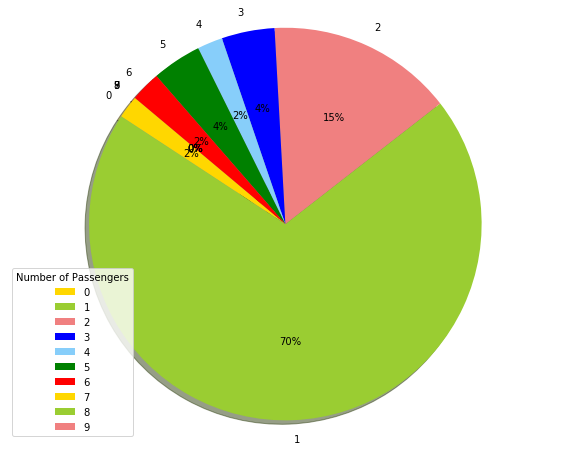

In [29]:
colors = ['gold', 'yellowgreen', 'lightcoral', 'blue', 'lightskyblue', 'green', 'red']

plt.figure(figsize=(10,8))
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.0f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.legend(labels, loc="best", title = 'Number of Passengers')
plt.savefig('passengers.png')
plt.show()

In [90]:
trip = data.select('trip_distance').filter((data.trip_distance >= 0) & (data.trip_distance < 30))

In [ ]:
hists_trip = data.select('trip_distance').rdd.flatMap(lambda row: row).histogram(200)

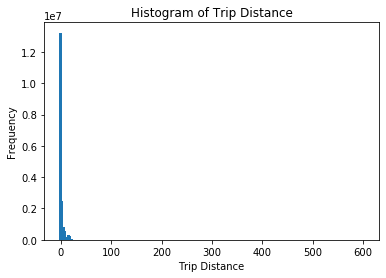

In [47]:
data_hist = {
    'bins': hists_trip[0][:-1],
    'freq': hists_trip[1]
    }
plt.bar(data_hist['bins'], data_hist['freq'], width=5)
plt.title('Histogram of ' + 'Trip Distance')
plt.ylabel('Frequency')
plt.xlabel('Trip Distance')
plt.savefig('TripDistance.png')

In [2]:
!jupyter nbconvert --to pdf explorationSummary.ipynb

[NbConvertApp] Converting notebook explorationSummary.ipynb to pdf
[NbConvertApp] Support files will be in explorationSummary_files/
[NbConvertApp] Making directory ./explorationSummary_files
[NbConvertApp] Making directory ./explorationSummary_files
[NbConvertApp] Making directory ./explorationSummary_files
[NbConvertApp] Making directory ./explorationSummary_files
[NbConvertApp] Making directory ./explorationSummary_files
[NbConvertApp] Making directory ./explorationSummary_files
[NbConvertApp] Writing 74442 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 590460 bytes to explorationSummary.pdf
